# Working Notebook

__Phase 3 Project - Chicago Traffic Crash Classification__

### Business Understanding

### Data Understanding and Preparation

Load dependencies

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, fbeta_score
from sklearn.model_selection import train_test_split, GridSearchCV,\
RandomizedSearchCV, cross_validate, cross_val_predict, cross_val_score


In [97]:
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning)

Import data files

In [98]:
crashes = pd.read_csv('data/Traffic_Crashes_-_Crashes.csv', low_memory=False)
people = pd.read_csv('data/Traffic_Crashes_-_People.csv', low_memory=False)
#vehicles = pd.read_csv('Chicago-Crashes/data/Traffic_Crashes_-_Vehicles.csv', low_memory=False)

In [4]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541142 entries, 0 to 541141
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                541142 non-null  object 
 1   RD_NO                          536550 non-null  object 
 2   CRASH_DATE_EST_I               41029 non-null   object 
 3   CRASH_DATE                     541142 non-null  object 
 4   POSTED_SPEED_LIMIT             541142 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         541142 non-null  object 
 6   DEVICE_CONDITION               541142 non-null  object 
 7   WEATHER_CONDITION              541142 non-null  object 
 8   LIGHTING_CONDITION             541142 non-null  object 
 9   FIRST_CRASH_TYPE               541142 non-null  object 
 10  TRAFFICWAY_TYPE                541142 non-null  object 
 11  LANE_CNT                       198968 non-null  float64
 12  ALIGNMENT                     

In [5]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195747 entries, 0 to 1195746
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              1195747 non-null  object 
 1   PERSON_TYPE            1195747 non-null  object 
 2   CRASH_RECORD_ID        1195747 non-null  object 
 3   RD_NO                  1185613 non-null  object 
 4   VEHICLE_ID             1172146 non-null  float64
 5   CRASH_DATE             1195747 non-null  object 
 6   SEAT_NO                244512 non-null   float64
 7   CITY                   879728 non-null   object 
 8   STATE                  890189 non-null   object 
 9   ZIPCODE                803192 non-null   object 
 10  SEX                    1177665 non-null  object 
 11  AGE                    852450 non-null   float64
 12  DRIVERS_LICENSE_STATE  705542 non-null   object 
 13  DRIVERS_LICENSE_CLASS  608027 non-null   object 
 14  SAFETY_EQUIPMENT  

Remove columns with 80% or more of null values.

In [99]:
df_list=[crashes, people]
for df in df_list:
    min_count =  int((20/100)*df.shape[0] + 1)
    df = df.dropna(axis=1, thresh=min_count, inplace=True)

Drop columns that will not be used

In [100]:
crashes_mod = crashes.drop(['CRASH_DATE','RD_NO','REPORT_TYPE', 'DATE_POLICE_NOTIFIED', 'STREET_NO', 
              'STREET_DIRECTION', 'STREET_NAME', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
             'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 
             'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN'], axis =1)

In [101]:
people_mod = people.drop(['CITY', 'ZIPCODE','RD_NO'], axis =1)

In [9]:
people_mod.shape

(1195747, 19)

In [10]:
crashes_mod.shape

(541142, 26)

## First Simple Model

In [11]:
crashes.MOST_SEVERE_INJURY.value_counts()

NO INDICATION OF INJURY     468994
NONINCAPACITATING INJURY     39675
REPORTED, NOT EVIDENT        21763
INCAPACITATING INJURY         9040
FATAL                          547
Name: MOST_SEVERE_INJURY, dtype: int64

Set up target variable:
 - 0: NO INDICATION OF INJURY, NONINCAPACITATING INJURY, REPORTED, NOT EVIDENT
 - 1: INCAPACITATING INJURY, FATAL
 

In [102]:
crashes['TARGET']= crashes['MOST_SEVERE_INJURY'].map({'NO INDICATION OF INJURY': 0,
                                                      'NONINCAPACITATING INJURY': 0,
                                                      'REPORTED, NOT EVIDENT': 0,
                                                      'INCAPACITATING INJURY': 1,
                                                      'FATAL': 1})

In [103]:
crashes.TARGET.fillna(0, inplace=True)

In [104]:
crashes.TARGET.value_counts()

0.0    531555
1.0      9587
Name: TARGET, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
X = crashes.drop(['MOST_SEVERE_INJURY','INJURIES_TOTAL', 'INJURIES_FATAL','INJURIES_INCAPACITATING',
                      'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
                      'INJURIES_NO_INDICATION', 'TARGET', 'CRASH_RECORD_ID', 'CRASH_DATE', 'LATITUDE', 
                      'LONGITUDE','LOCATION'], axis=1)
y = crashes['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

__FIRST SIMPLE MODEL - DUMMY CLASSIFIER__

In [16]:
X_train_nums = X_train.select_dtypes(include=['float64', 'int64'])
X_train_cat = X_train.select_dtypes('object')

In [17]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                         sparse=False))
])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [18]:
dummy_pipe = Pipeline(steps=[
    ('trans', trans),
    ('dc', DummyClassifier(strategy='most_frequent'))
])

In [105]:
from sklearn.model_selection import cross_validate

def print_cv_scores(pipe, X, y):
    
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True)
    
    print(results['train_score'])
    print(results['train_score'].mean())
    print('##############')
    print(results['test_score'])
    print(results['test_score'].mean())

In [1]:
#print_cv_scores(dummy_pipe, X_train, y_train)

NameError: name 'print_cv_scores' is not defined

### Merging Dataframes

From the people data, the target will be the injury classification so that the model will predict the severity of injuries.

In [106]:
people_mod.INJURY_CLASSIFICATION.value_counts()

NO INDICATION OF INJURY     1096283
NONINCAPACITATING INJURY      55296
REPORTED, NOT EVIDENT         32092
INCAPACITATING INJURY         10827
FATAL                           656
Name: INJURY_CLASSIFICATION, dtype: int64

To avoid too many repeated rows from crashes_dropped_df, we'll use the `CRASH_RECORD_ID` to only merge in rows from people_dropped_df where `DRIVER_TYPE == DRIVER`, then use the `VEHICLE_ID` to only merge in that driver's vehicle from vehicles_dropped_df.

This will allow us to still retain over 75% of the rows from people.

In [107]:
people_mod.PERSON_TYPE.value_counts(normalize=True)

DRIVER                 0.776163
PASSENGER              0.204485
PEDESTRIAN             0.011393
BICYCLE                0.006911
NON-MOTOR VEHICLE      0.000866
NON-CONTACT VEHICLE    0.000181
Name: PERSON_TYPE, dtype: float64

In [108]:
people_crashes_df = people_mod.merge(crashes_mod, on='CRASH_RECORD_ID', how='left')

In [23]:
people_crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195747 entries, 0 to 1195746
Data columns (total 44 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PERSON_ID                1195747 non-null  object 
 1   PERSON_TYPE              1195747 non-null  object 
 2   CRASH_RECORD_ID          1195747 non-null  object 
 3   VEHICLE_ID               1172146 non-null  float64
 4   CRASH_DATE               1195747 non-null  object 
 5   SEAT_NO                  244512 non-null   float64
 6   STATE                    890189 non-null   object 
 7   SEX                      1177665 non-null  object 
 8   AGE                      852450 non-null   float64
 9   DRIVERS_LICENSE_STATE    705542 non-null   object 
 10  DRIVERS_LICENSE_CLASS    608027 non-null   object 
 11  SAFETY_EQUIPMENT         1192258 non-null  object 
 12  AIRBAG_DEPLOYED          1173141 non-null  object 
 13  EJECTION                 1181206 non-null 

In [109]:
people_crashes_df.INJURY_CLASSIFICATION.value_counts()

NO INDICATION OF INJURY     1096283
NONINCAPACITATING INJURY      55296
REPORTED, NOT EVIDENT         32092
INCAPACITATING INJURY         10827
FATAL                           656
Name: INJURY_CLASSIFICATION, dtype: int64

In [110]:
people_crashes_df['TARGET'] = people_crashes_df['INJURY_CLASSIFICATION'].map({np.nan: 0,
                                                      'NO INDICATION OF INJURY': 0,
                                                      'NONINCAPACITATING INJURY': 1,
                                                      'REPORTED, NOT EVIDENT': 1,
                                                      'INCAPACITATING INJURY': 2,
                                                      'FATAL': 3})

In [111]:
people_crashes_df['CRASH_YEAR']=pd.to_datetime(people_crashes_df['CRASH_DATE']).dt.year

In [112]:
people_crashes_df['CRASH_YEAR'].value_counts()

2018    265694
2019    263972
2020    202084
2017    185328
2021    161704
2016     96020
2015     20931
2014        11
2013         3
Name: CRASH_YEAR, dtype: int64

In [113]:
# Drop nulls from BEAT_OF_OCCURRENCE
people_crashes_df.dropna(subset = ['BEAT_OF_OCCURRENCE'], inplace=True)

# Drop ages < 0 and ages = 0 for DRIVER
people_crashes_df.loc[people_crashes_df.AGE < 0, 'AGE'] = np.nan
people_crashes_df.loc[(people_crashes_df.AGE == 0) & (people_crashes_df.PERSON_TYPE == 'DRIVER'), 'AGE'] = np.nan
people_crashes_df.dropna(subset = ['AGE'], inplace=True)

# Drop POSTED_SPEED_LIMIT = 0 or not divisible by 5
people_crashes_df.loc[people_crashes_df.POSTED_SPEED_LIMIT == 0, 'POSTED_SPEED_LIMIT'] = np.nan
people_crashes_df.loc[(people_crashes_df.POSTED_SPEED_LIMIT % 5) != 0, 'POSTED_SPEED_LIMIT'] = np.nan
people_crashes_df.dropna(subset = ['POSTED_SPEED_LIMIT'], inplace=True)

__Train Test Split__

In [114]:
from sklearn.model_selection import train_test_split
X = people_crashes_df.drop(['PERSON_ID', 'CRASH_RECORD_ID','LANE_CNT', 'VEHICLE_ID','CRASH_DATE', 'CRASH_TYPE', 'LATITUDE', 
                            'INJURY_CLASSIFICATION','DRIVERS_LICENSE_STATE','LONGITUDE','LOCATION', 'TARGET'], axis=1)
y = people_crashes_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

__Reduce the features based on iterations of models__

In [115]:
X_train_smaller = X_train[['PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AGE', 'AIRBAG_DEPLOYED', 
                           'EJECTION', 'DRIVER_ACTION', 'SEAT_NO', 'LIGHTING_CONDITION', 'WEATHER_CONDITION', 
                           'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 
                           'BEAT_OF_OCCURRENCE', 'NUM_UNITS']]

In [32]:
# X_test_smaller = X_test[['PERSON_TYPE', 'SEX', 'SAFETY_EQUIPMENT', 'AGE', 'AIRBAG_DEPLOYED', 
#                            'EJECTION', 'DRIVER_ACTION', 'SEAT_NO', 'LIGHTING_CONDITION', 'WEATHER_CONDITION', 
#                            'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 
#                            'BEAT_OF_OCCURRENCE', 'NUM_UNITS']]

In [33]:
# for i in range(len(X_train.columns)):
#     print(X_train[X_train.columns[i]].value_counts())
#     print(X_train[X_train.columns[i]].isna().sum())
#     print('--------------------')

__Create functions to clean the data__

In [116]:
from sklearn.preprocessing import FunctionTransformer

def seat_no_transformer(df):
    '''
    Set all SEAT_NO = 1 if PERSON_TYPE = 'DRIVER'
    and fill the rest with 0.
    '''
    df.loc[(df.PERSON_TYPE == 'DRIVER'), 'SEAT_NO'] = 1
    df['SEAT_NO'].fillna(value=0, inplace=True)
    return df

In [35]:
# def age_transformer(df):
#     df['AGE'][df.AGE < 0] = np.nan
#     df.loc[(df.AGE==0)&(df.PERSON_TYPE == 'DRIVER')]['AGE'] = np.nan
#     df.AGE.dropna(inplace=True)
#     return df

In [36]:
# def speed_transformer(df):
#     df['POSTED_SPEED_LIMIT'][df.POSTED_SPEED_LIMIT == 0] = np.nan
#     df['POSTED_SPEED_LIMIT'][(df.POSTED_SPEED_LIMIT %5) != 0] = np.nan
#     df.POSTED_SPEED_LIMIT.dropna(inplace=True)
#     return df

In [117]:
def beat_transformer(df):
    '''
    Extract and encode as a string the district
    from BEAT_OF_OCCURRENCE.
    '''
    df['BEAT_OF_OCCURRENCE'] = df['BEAT_OF_OCCURRENCE'].apply(str)
    df['BEAT_OF_OCCURRENCE'] = df['BEAT_OF_OCCURRENCE'].apply(lambda x: x[:-4])
    # df.drop('BEAT_OF_OCCURRENCE', axis=1, inplace=True)
    return df

In [118]:
def license_class_transformer(df):
    '''
    Bin all license classes into A, B, C, D, and OTHER
    '''
    dl_classes = ['A', 'B', 'C', 'D', np.nan]
    df.loc[df['DRIVERS_LICENSE_CLASS'].isin(dl_classes) == False, 'DRIVERS_LICENSE_CLASS'] = 'OTHER'
    return df

In [119]:
def to_float_transformer(df):
    '''
    Ensure all columns are float, not int.
    '''
    for col in [df.select_dtypes('int64').columns]:
        df[col] = df[col].astype('float64')
    return df

In [120]:
def fill_categories(df):
    '''
    Fill null values with given value for 
    unknown values in that column.
    Drop all remaining nulls.
    '''
    df.fillna({#'STATE':'XX', 
               # 'DRIVERS_LICENSE_STATE':'XX', # This col now dropped before train-test-split
               #'DRIVERS_LICENSE_CLASS': 'D', # Most common; D = 'normal' drivers license for cars
               'EJECTION': 'UNKNOWN',
               'DRIVER_ACTION': 'UNKNOWN',
               #'DRIVER_VISION': 'UNKNOWN',
               #'PHYSICAL_CONDITION': 'UNKNOWN',
               'SAFETY_EQUIPMENT': 'USAGE_UNKNOWN',
               'AIRBAG_DEPLOYED': 'DEPLOYMENT_UNKNOWN',
               'SEX': 'UNKNOWN',
               #'INTERSECTION_RELATED_I': 'N',
               #'HIT_AND_RUN_I': 'N',
               #'BAC_RESULT': 'TEST NOT OFFERED'
              }, inplace=True)
    return df

In [121]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

ohe_cols = list(X_train_smaller.select_dtypes('object').columns)
ohe_cols.append('BEAT_OF_OCCURRENCE')


# OneHotEncode the columns as part of cleaning
# to avoid needing to separate numerical and categorical
# columns later
ohe_col_trans = ColumnTransformer(transformers=
                                     [('ohe', OneHotEncoder(drop='first', sparse=False), 
                                       ohe_cols)],
                                 remainder='passthrough')

# Apply all our cleaning functions, then finish with ohe
cleaning_pipeline = Pipeline(steps=[
    ('seat_no', FunctionTransformer(seat_no_transformer)),
#     ('age', FunctionTransformer(age_transformer)),
    ('beat', FunctionTransformer(beat_transformer)),
#     ('speed', FunctionTransformer(speed_limit_transformer)),
#     ('license', FunctionTransformer(license_class_transformer)),
    ('fill_cat', FunctionTransformer(fill_categories)),
    ('float', FunctionTransformer(to_float_transformer)),
    ('col_trains', ohe_col_trans)
])

__Fit the cleaning pipeline to prepare data for a model__

In [42]:
#X_train_clean = cleaning_pipeline.fit_transform(X_train)
#X_test_clean = cleaning_pipeline.transform(X_test)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-37-41f05342683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [122]:
X_train_smaller_clean = cleaning_pipeline.fit_transform(X_train_smaller)
#X_test_smaller_clean = cleaning_pipeline.transform(X_test)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-117-41f05342683b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

__Use SMOTE to resample to deal with the class imbalance__

In [123]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_smaller_clean, y_train)

__LOGISTIC REGRESSION - ITERATION 1__

In [43]:
lr_pipe1 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced'))
])

In [42]:
def print_cv_scores(pipe, X, y):
    
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True)
    
    print(results['train_score'])
    print(results['train_score'].mean())
    print('##############')
    print(results['test_score'])
    print(results['test_score'].mean())

In [47]:
print_cv_scores(lr_pipe1, X_train_smaller_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

[0.74748576 0.74876755 0.74943934 0.74928585 0.74927638]
0.7488509759823703
##############
[0.74679255 0.75107447 0.74639386 0.74685634 0.74993222]
0.7482098857870877


In [53]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_recall_fscore_support

y_pred = cross_val_predict(lr_pipe1, X_train_smaller_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [55]:
confusion_matrix(y_train, y_pred, normalize='true')

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.79395828, 0.14937041, 0.03379528, 0.02287603],
       [0.29256945, 0.3720424 , 0.22806726, 0.10732088],
       [0.15588433, 0.24761264, 0.35722932, 0.23927371],
       [0.03791469, 0.05687204, 0.22274882, 0.68246445]])

In [56]:
precision_recall_fscore_support(y_train, y_pred, average='macro')

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.31395005064088854, 0.5514236147732384, 0.3215327917780622, None)

__LOGISTIC REGRESSION - ITERATION 2__

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

lr_pipe2 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              max_iter=1000,
                              random_state=42,
                              C = 0.001))
])

In [59]:
print_cv_scores(lr_pipe2, X_train_smaller_clean, y_train)

[0.74921209 0.75071515 0.75098227 0.75160822 0.75120603]
0.7507447522616543
##############
[0.74898534 0.75282073 0.74794077 0.74941592 0.75196555]
0.7502256611709548


In [60]:
y_pred = cross_val_predict(lr_pipe2.steps[1][1], X_train_smaller_clean, y_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/

In [61]:
confusion_matrix(y_train, y_pred, normalize='true')

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.80079891, 0.14168365, 0.03083113, 0.02668632],
       [0.30413399, 0.34354646, 0.22964575, 0.1226738 ],
       [0.16785474, 0.22434432, 0.34418292, 0.26361802],
       [0.04976303, 0.05924171, 0.18246445, 0.70853081]])

In [62]:
precision_recall_fscore_support(y_train, y_pred, average='macro')

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.31244886950380907, 0.5492647724802594, 0.3191111100095438, None)

In [88]:
# def print_logreg_coefs(cleaning_pipeline, model_pipeline, thresh=0.05, return_list=False):
#     ohe_feature_names = cleaning_pipeline.steps[-1][1].get_feature_names()
#     lr_coefs = model_pipeline.steps[1][1].coef_
#     result = []
    
#     for i in range(len(lr_coefs)):
#         print('Coefs for features in class ', i)
#         for j in range(len(ohe_feature_names)):
#             if abs(lr_coefs[i][j] >= thresh):
#                 print(ohe_feature_names[j], ': ', lr_coefs[i][j])
#                 result.append(ohe_feature_names[j], lr_coefs[i][j])
#         print('='*30, '\n')
        
#     if return_list:
#         return result
#     else:
#         return

In [91]:
# print_logreg_coefs(cleaning_pipeline, lr_pipe2, thresh=0.05, return_list=False)

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [ ]:
# model_pipe = Pipeline(steps=[
#     ('ss', StandardScaler()),
#     ('lr', LogisticRegression(random_state=42))
# ])

In [ ]:
# pipe_grid = {
#     'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'lr__penalty': ['l1', 'l2'],
#     'lr__max_iter': list(range(100,800,100)),
#     'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'lr__class_weight': ['balanced']
# }
# gs_pipe = GridSearchCV(estimator=model_pipe, param_grid=pipe_grid)

In [ ]:
# gs_pipe.fit(X_train_clean, y_train)

In [ ]:
# gs_pipe.best_params_
# print('Mean Accuracy: %.3f' % gs_pipe.best_score_)
# print('Config: %s' % gs_pipe.best_params_)

__RANDOM FOREST - ITERATION 1__

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth = 4,
                                  n_estimators = 50,
                                  random_state = 42))
])

In [48]:
print_cv_scores(rf_pipe, X_res, y_res)

[0.59241822 0.59518873 0.59347444 0.59299088 0.59138929]
0.5930923119657239
##############
[0.585245   0.59647907 0.59436954 0.59391561 0.59298316]
0.5925984742183479


In [49]:
y_pred = cross_val_predict(rf_pipe.steps[1][1], X_res, y_res)

In [50]:
confusion_matrix(y_res, y_pred, normalize='true')

array([[0.90715958, 0.05203099, 0.0103003 , 0.03050913],
       [0.40517305, 0.2388567 , 0.18885965, 0.1671106 ],
       [0.17407466, 0.18621392, 0.29190734, 0.34780408],
       [0.00570291, 0.01147379, 0.05035303, 0.93247026]])

In [53]:
precision_recall_fscore_support(y_res, y_pred, average='macro')

(0.5667378084169745, 0.5925984726652154, 0.5450818732642582, None)

In [57]:
fbeta_score(y_res, y_pred, average='macro', beta=1e5)

0.5925984726493148

In [64]:
rf_pipe.fit(X_res, y_res)

Pipeline(steps=[('ss', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=4, n_estimators=50,
                                        random_state=42))])

Feature: 0, Score: 0.01989
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00019
Feature: 3, Score: 0.00221
Feature: 4, Score: 0.03170
Feature: 5, Score: 0.01995
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00253
Feature: 17, Score: 0.00002
Feature: 18, Score: 0.01056
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.01100
Feature: 21, Score: 0.07703
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.03511
Feature: 25, Score: 0.00192
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.03672
Feature: 28, Score: 0.01684
Feature: 29, Score: 0.00002
Feature: 30, Score: 0.00125
Feature: 31, Score: 0.01900
Feature: 32, Score: 0.08764
Feature: 33, Score: 0.00705
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.01255
Fe

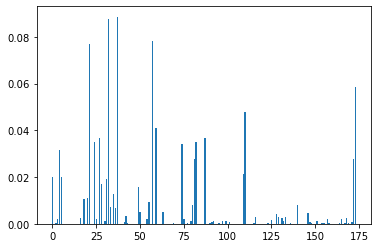

In [82]:
# summarize feature importance
importance = rf_pipe[1].feature_importances_
ohe_feature_names = cleaning_pipeline.steps[-1][1].get_feature_names()
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# for i in range(len(importance)):
#     if importance >= 0.05:
#         print(ohe_feature_names[i], ': ', importance[i])

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [87]:
#Score: 0.08864
ohe_feature_names[37]

'ohe__x4_UNKNOWN'

In [86]:
#Score: 0.08764
ohe_feature_names[32]

'ohe__x3_DID NOT DEPLOY'

In [92]:
#Score: 0.07805
ohe_feature_names[57]

'ohe__x6_DARKNESS, LIGHTED ROAD'

In [84]:
#Score: 0.07703
ohe_feature_names[21]

'ohe__x2_SAFETY BELT USED'

In [85]:
#Score: 0.05866
ohe_feature_names[173]

'NUM_UNITS'

In [93]:
#Score: 0.04796
ohe_feature_names[110]

'ohe__x10_OVER $1,500'

In [ ]:
feature_name = cleaning_pipeline.steps[-1][1].get_feature_names()
importance = [0.00254953, 0., 0.00233605, 0.00184723, 0.00097822, 0.00190925, 0.00063667, 0., 0.00207959, 0.00255143, 0., 0.00347863, 0.00226279, 0.019971, 0.00513911, 0., 0.00307888, 0.00187971, 0.00106023, 0.00102159, 0., 0.001242, 0.00136372, 0.00363245, 0.00165718, 0.0008518, 0., 0.0026852, 0., 0.00122229, 0.00111545, 0.00087373, 0.00911209, 0.0021856, 0.00044858, 0.00141463, 0.00124821, 0.00159017, 0., 0., 0., 0.00283378, 0.00171399, 0., 0.00199945, 0., 0.00118223, 0.00668535, 0., 0.00109466, 0.00401093, 0.00388916, 0.00272809, 0.01884322, 0.0045156, 0.00133088, 0., 0.00217315, 0.00772509, 0.0006892, 0.00263684, 0.01616743, 0.00812377, 0.00607146, 0., 0.00184517, 0.01411981, 0.00183418, 0.01307631, 0.00462931, 0.00542847, 0.01481777, 0.00219632, 0.00650142, 0.00336755, 0.06709845, 0.01570165, 0.0232122, 0.018059, 0.00679315, 0.00429122, 0.00489835, 0.00014759, 0.00165096, 0.00513983, 0.0291157, 0., 0.00671592, 0.00109376, 0.00371024, 0.00182787, 0.0051496, 0.01043787, 0.00372879, 0., 0.00559065, 0.01502675, 0.00993086, 0.00306601, 0.00369758, 0.02638649, 0., 0.00930436, 0.00256558, 0.00698451, 0.00583299, 0.0006391, 0.00265303,
 0.00595531, 0.00678822, 0.00479762, 0.00296563, 0.00327525, 0.00279237,
 0.00119998, 0.00966071, 0.00869574, 0.01835277, 0.01679247, 0.00308825,
 0.00769471, 0.00518557, 0.01508538, 0.0037915,  0.0202597,  0.02124231,
 0.00208727, 0.00147029, 0.00210141, 0.0062456,  0.00509456, 0.00592563,
 0.00197763, 0.00795799, 0.00341921, 0.00718072, 0.01116631, 0.00868733,
 0.01067301, 0.00586468, 0.00808448, 0.00534105, 0.01213205, 0.00776362,
 0.01058323, 0.00266318, 0.00400647, 0.00865966, 0.00993486, 0.00619971,
 0.00205991, 0.02401683, 0.00155812, 0.00779086, 0.00091193, 0.00621508,
 0.00085267, 0.00121016, 0.00165691, 0.00142914, 0.00274774, 0.02355196,
 0.00613796, 0.00533831, 0.00463595, 0.00795607, 0.00843228, 0.01086943,
 0.00825049, 0.01543103]
# summarize feature importance
for i,v in enumerate(importance):
    if v > 0.0001:
        print('Feature: %s, Score: %.5f' % (feature_name[i],v))

__XGBoost Classifier__

In [124]:
X_res.shape

(2236052, 174)

In [128]:
xgb_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42,
                          max_depth = 5,
                          tree_method='hist',
                          n_estimators = 50,
                          n_jobs = -1))
])

In [129]:
xgb_pipe.fit(X_res, y_res)

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='hist',
                               validate_parameters=1, verbosity=None))])

In [130]:
print_cv_scores(xgb_pipe, X_res, y_res)

[0.83184531 0.81999462 0.82042796 0.82094618 0.82140401]
0.8229236178309695
##############
[0.76820561 0.83160745 0.83120011 0.83187317 0.83183516]
0.8189442991824585


In [135]:
feature_name = cleaning_pipeline.steps[-1][1].get_feature_names()
importance = xgb_pipe[1].feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    if v > 0.01:
        print('Feature: %s, Score: %.5f' % (feature_name[i],v))

Feature: ohe__x0_PASSENGER, Score: 0.01411
Feature: ohe__x1_M, Score: 0.01960
Feature: ohe__x2_SAFETY BELT USED, Score: 0.05224
Feature: ohe__x2_USAGE UNKNOWN, Score: 0.01290
Feature: ohe__x3_DEPLOYMENT UNKNOWN, Score: 0.01799
Feature: ohe__x3_DID NOT DEPLOY, Score: 0.04446
Feature: ohe__x3_NOT APPLICABLE, Score: 0.03277
Feature: ohe__x4_TOTALLY EJECTED, Score: 0.01490
Feature: ohe__x4_TRAPPED/EXTRICATED, Score: 0.01133
Feature: ohe__x4_UNKNOWN, Score: 0.01894
Feature: ohe__x5_NONE, Score: 0.01294
Feature: ohe__x5_TOO FAST FOR CONDITIONS, Score: 0.01211
Feature: ohe__x6_DARKNESS, LIGHTED ROAD, Score: 0.02240
Feature: ohe__x6_DAYLIGHT, Score: 0.01027
Feature: ohe__x7_CLEAR, Score: 0.01593
Feature: ohe__x8_FIXED OBJECT, Score: 0.03136
Feature: ohe__x8_PEDALCYCLIST, Score: 0.01727
Feature: ohe__x8_REAR END, Score: 0.01182
Feature: ohe__x8_SIDESWIPE SAME DIRECTION, Score: 0.01514
Feature: ohe__x9_NOT DIVIDED, Score: 0.01184
Feature: ohe__x10_OVER $1,500, Score: 0.02026
Feature: ohe__x11_FA